# Web Log Mining for Content Optimization using Apriori Algorithm

##### Web mining process can be defined as the process of applying data mining algorithms or techniques on web data so as to to discover the interesting or access patterns or knowledge to study user behaviour or user access patterns

In [2]:
#Import required libraries
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
from apyori import apriori

In [3]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('float_format', '{:f}'.format)

#### Table of Contents

- Business Understanding
- Data Gathering
- Data Cleaning
- Exploratory Data Analysis
- Data Transformation
- Data Modelling
- Results/Evaluation
- Conclusions

### Business Understanding

######  World Wide Web has become a huge repository for retrieving, placing, sharing and also distributing the data. Web is a dominant platform from where the knowledge can be discovered to study user behaviour . Each and every interaction of web user with the web will be recorded or stored in WEB LOG file. 

###### The data contains NASA web access logs for two months (July and August) which can be used for identifying different user patterns. What we are trying to analyze here is:
-            1)How to optimize content based on the visitor usage and access patterns of the users.
-            2)Who are the top 10 users and which websites are accessed the most?
-            3)How many unique hosts access NASA websites and what is the average daily request per host.


### Data Gathering

###### NASA web access log data for two months (July and August) is publicly available and can be downloaded from http://opensource.indeedeng.io/imhotep/docs/sample-data.  Download and extract data from .gz files and import into a dataframe.


In [4]:
#Import datasets
data_path = os.path.join(os.path.abspath('./data'))
files_in_folder = [os.path.join(data_path, file) for file in os.listdir(data_path)]

df = pd.DataFrame()
for file in files_in_folder:
    temp_df = pd.read_csv(file)
    df = pd.concat([df, temp_df])

# df1 = pd.read_csv(r"19950801.00-19950901.00.tsv", sep="\t", encoding="ISO-8859-1")
# df2 = pd.read_csv(r"19950630.23-19950801.00.tsv", sep="\t", encoding="ISO-8859-1")

In [5]:
# #combine both the datasets.
# df = pd.concat([df1,df2])

### Data Cleaning

In [6]:
#check for columns with all null value
df.isnull().values.all(axis=0)

array([False, False, False, False, False, False, False,  True,  True])

In [7]:
#check for column with any null value
df.isnull().values.any(axis=0)

array([False, False, False, False, False, False, False,  True,  True])

In [8]:
###### columns 'referer', 'useragent' contain all null values and 'logname' has all '-' values. Hence will be dropped
df = df.loc[:,~df.columns.isin(['referer', 'useragent', 'logname'])]

######  Removing unwanted files or pages or URLs include removing urls's which are not required for a praticular use case scenario. Here we will keep only the urls' with  extension “.html” and remove records with other extensions like “gif”, “jpeg”, “css” and so on .

###### Records with error status codes are also removed. 

### HTTP Status Messages

###### 200:Successful:OK - The request is OK (this is the standard response for successful HTTP requests)
###### 302:Redirection:Found: - The requested page has moved temporarily to a new URL 
###### 304:Redirection:Not Modified:-Indicates the requested page has not been modified since last requested
###### 403:Client Error:Forbidden:-The request was a legal request, but the server is refusing to respond to it
###### 404:Client Error:Not Found:-The requested page could not be found but may be available again in the future
###### 500:Server Error:-Internal Server Error:-A generic error message, given when no more specific message is suitable
###### 501:Server Error:Not Implemented:-The server either does not recognize the request method, or it lacks the ability to fulfill the request

In [10]:
df['ext'] = df['url'].str.split('.').str[-1]
df['ext'] = df['ext'].str.lower()

In [11]:
#Removing unwanted rows
df_cleaned = df[(df['ext']=='html') & (df['response']<400)]

### Exploratory Data Analysis

In [16]:
#Create timestamp column by converting time variable to datetime format
df['timestamp']= list(map(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'), df['time']))
df=df.drop(columns = 'time')

In [17]:
df['timestamp'] = pd.to_datetime(df.timestamp)
df["date"]=df['timestamp'].dt.strftime("%Y-%m-%d")
df["time"]=df['timestamp'].dt.strftime("%H:%M:%S")

In [18]:
df['day'] = df.timestamp.dt.day
df['month'] = df.timestamp.dt.month
df['weekday']= df.timestamp.dt.day_name()
df['hour']= df.timestamp.dt.hour
df['minute']= df.timestamp.dt.minute
df['second']= df.timestamp.dt.second

In [20]:
count_day_month = df.groupby(['month','day'], as_index=False).count()

In [21]:
print('unique days in month 7 : {}'.format(count_day_month[count_day_month['month']==7]['day'].nunique()))
print('unique days in month 8 : {}'.format(count_day_month[count_day_month['month']==8]['day'].nunique()))
print('unique days in month 9 : {}'.format(count_day_month[count_day_month['month']==9]['day'].nunique()))

unique days in month 7 : 29
unique days in month 8 : 31
unique days in month 9 : 1


##### It was mentioned in the description that data provided is for the month of July and August,1995. However we see that we have data for the month of september as well. 

In [22]:
# As there is just one day data for the month of september, dropping it from the dataset
df = df[df['month']!=9]

### How many unique hosts access NASA websites and what is the average daily request per host.

In [23]:
uniq_host = df.host.nunique()
print("Unique hosts : {}".format(uniq_host))

Unique hosts : 136177


In [24]:
uniq_url = df.url.nunique()
print("Unique url : {}".format(uniq_url))

Unique url : 30732


In [25]:
#count unique daily hosts
unq_daily_hosts= df.groupby(['month','day'],as_index=False).agg({"host": 'count', "host":pd.Series.nunique})

Text(0.5, 1.0, 'Daily unique hosts')

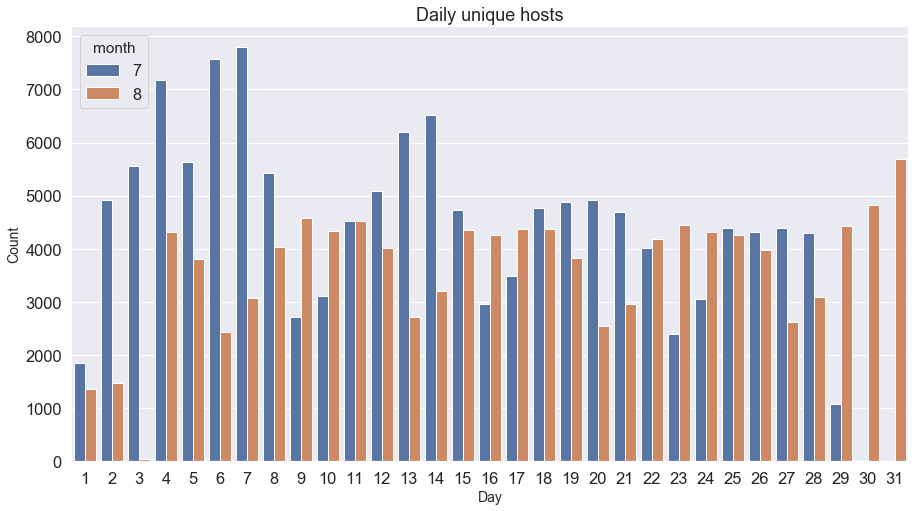

In [31]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(15, 8))
sns.barplot(x="day", 
            y="host", 
            hue="month", 
            data=unq_daily_hosts)
plt.ylabel("Count", size=14)
plt.xlabel("Day", size=14)
plt.title("Daily unique hosts", size=18)

##### There is a difference in usage on websites for the month of July and August. Usage for the month of August is considerably low compared to the month of July. This is due to Shuttle Missions in the month of July.

In [27]:
#count total daily hosts
total_daily_hosts = df.groupby(['month','day'], as_index=False)['host'].count()

In [28]:
#Average daily request per host
avg_daily_req_per_host = total_daily_hosts['host']/unq_daily_hosts['host']

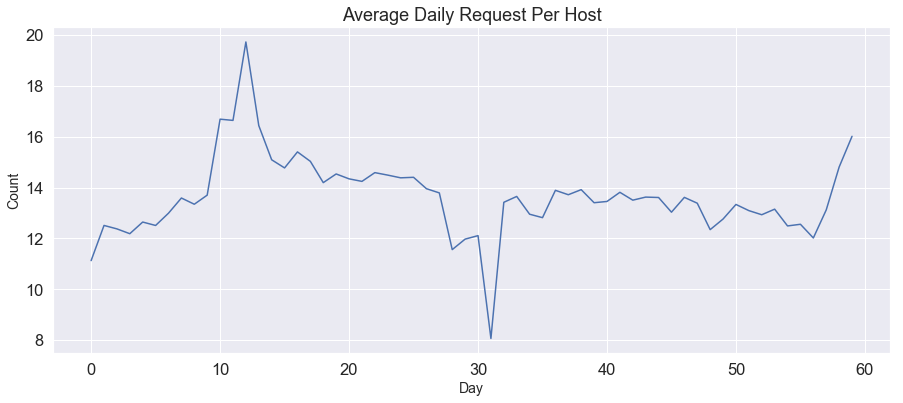

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,6 ))
plt.ylabel("Count", size=14)
plt.xlabel("Day", size=14)
plt.plot(avg_daily_req_per_host)
plt.title("Average Daily Request Per Host", size=18)
plt.show()

##### Average daily request per host saw its peak during the first half on the month of July due to shuttle missions, however there is significant drop in the number of request towards the end of July and beginning on the month of August. This pattern was due to Server Errors' at the NASA website

### Who are the top 10 users and which websites are accessed the most?

Text(0.5, 0, 'count')

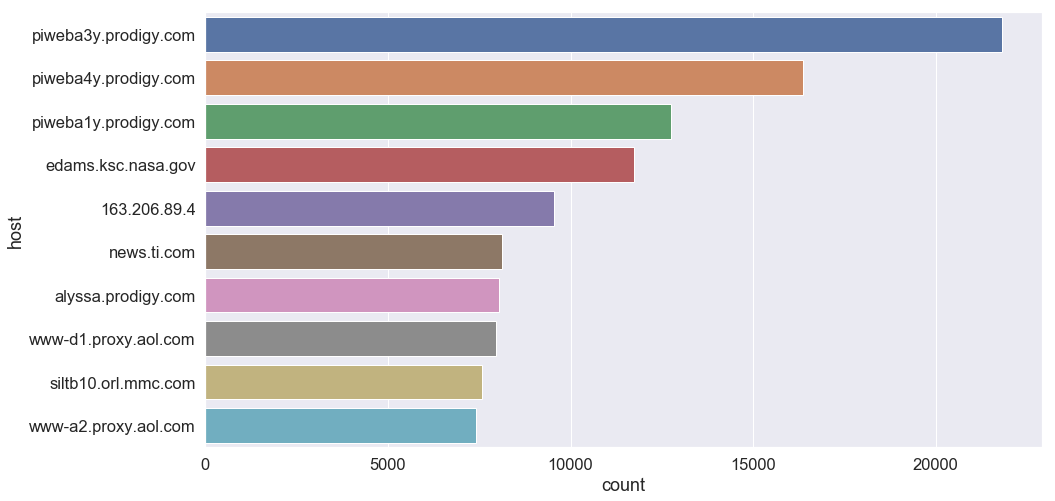

In [33]:
#Top 10 hosts
top_hosts = pd.DataFrame(df.host.value_counts()[:10]).reset_index()
top_hosts.columns = ['host', 'count']
plt.figure(figsize=(15,8))
ax = sns.barplot(x='count', y='host', data=top_hosts)
ax.set_xlabel('count')

Text(0.5, 0, 'count')

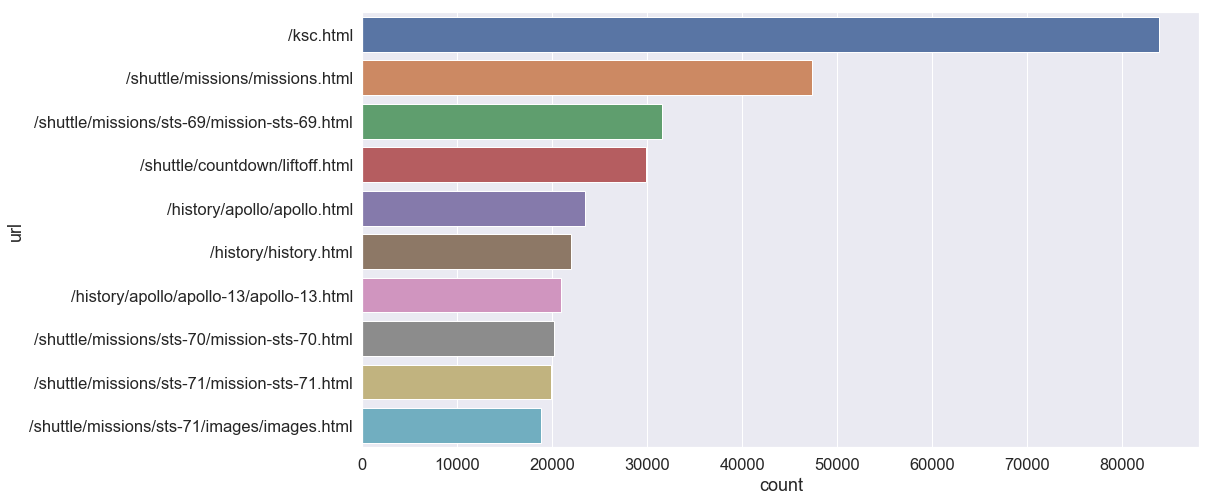

In [34]:
#Top 10 accessed URLs'
top_url = pd.DataFrame(df_cleaned.url.value_counts()[:10]).reset_index()
top_url.columns = ['url', 'count']
plt.figure(figsize=(15,8))
ax = sns.barplot(x='count', y='url', data=top_url)
ax.set_xlabel('count')

##### Above graphs provide insights about the most frequent users and most commonly accessed websites. PIWEBA group is most frequent user and KENNEDY SPACE CENTER is most accessed website. In the year 1995, NASA used to host its information via ksc websites.

### Data Transformation

In [35]:
def convert_to_id(dataframe):
    
    '''
      Names of hosts' and URLs' are very lengthy. To use them in the algorithm, and for easy interpretetion,
      assigning unique IDs to Host and URL.
      
      Function takes in a dataframe with host and url name and returns complete dataframe with new columsn for ID's 
      along with other columns 
    '''
    dataframe1 = dataframe.assign(host_id=(dataframe['host']).astype('category').cat.codes)
    dataframe2 = dataframe1.assign(url_id=(dataframe['url']).astype('category').cat.codes)
    dataframe2 = dataframe2.astype({"host_id":'category', "url_id":'category'})
    
    return dataframe2   

In [36]:
df_transformed = convert_to_id(df)

In [38]:
#subset the dataset to select the required columns for algorithm input
df_transformed = df_transformed[['date','url_id', 'host_id']]

In [39]:
#Pivot the dataset

df_transformed['idx'] = df_transformed.groupby('date').cumcount()
df_pivot = df_transformed.pivot(index='date',columns='idx')[['url_id']]

### Data Modelling

In [41]:
records = []
for i in range(0, 60): #no of rows
    records.append([str(df_pivot.values[i,j]) for j in range(0, 10)]) #Here we are selecting only 10 columns. 

In [42]:
association_rules = apriori(records, min_support=0.05, min_lift=4, min_length=2)
association_results = list(association_rules)

In [43]:
sort_df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

Support =[]
Confidence = []
Lift = []
Items = []
Antecedent = []
Consequent=[]

for RelationRecord in association_results:
    for ordered_stat in RelationRecord.ordered_statistics:
        Support.append(RelationRecord.support)
        Items.append(RelationRecord.items)
        Antecedent.append(ordered_stat.items_base)
        Consequent.append(ordered_stat.items_add)
        Confidence.append(ordered_stat.confidence)
        Lift.append(ordered_stat.lift)

sort_df['Items'] = list(map(set, Items))                                   
sort_df['Antecedent'] = list(map(set, Antecedent))
sort_df['Consequent'] = list(map(set, Consequent))
sort_df['Support'] = Support
sort_df['Confidence'] = Confidence
sort_df['Lift']= Lift

In [44]:
sort_df.sort_values(by ='Lift', ascending = False, inplace = True)

### Results/Evaluation

In [46]:
sort_df.head()

,Items,Antecedent,Consequent,Support,Confidence,Lift
14,"{19038, 19410}",{19038},{19410},0.050000,1.000000,20.000000
15,"{19038, 19410}",{19410},{19038},0.050000,1.000000,20.000000
0,"{24376, 18027}",{18027},{24376},0.050000,0.750000,15.000000
56,"{18578, 24355, 18591, 19043}","{24355, 18591, 19043}",{18578},0.050000,1.000000,15.000000
33,"{18578, 24355, 18591}","{24355, 18591}",{18578},0.050000,1.000000,15.000000


### Explaination of Support, confidence and lift

###### Support refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item  divided by total number of transactions
###### Support(B) = (Transactions containing (B))/(Total Transactions)


###### Confidence refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions  where A and B are bought together, divided by total number of transactions where A is bought
###### Confidence(A→B) = (Transactions containing both (A and B))/(Transactions containing A)


###### Lift(A -> B) refers to the increase in the ratio of sale of B when A is sold. Lift(A –> B) can be calculated by dividing Confidence(A -> B) divided by Support(B)

###### Lift(A→B) = (Confidence (A→B))/(Support (B))


##### Based on patterns provided in the output, web content can be optimised by checking for content similarity.

### Conclusion

##### From the results of the algorithm we can see that different access patterns of NASA Web logs by the users.
##### If websites with ID’s 568 and 552 are access then the use would definitely access website with ID 398. This is because the Confidence of the rule is 100% and Lift is 15 , which indicates that the rule is very strong
##### 568-/history/apollo/apollo.html
##### 552-/history/history.html
##### 398-/history/apollo/apollo13.html
##### Similarly we can analyze other interesting access patterns from the output.